In [114]:
#Classification Finetuning on sms spam

#Downloading dataset

import urllib.request
import ssl
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Create an unverified SSL context
    ssl_context = ssl._create_unverified_context()

    # Downloading the file
    with urllib.request.urlopen(url, context=ssl_context) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)




sms_spam_collection\SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [115]:
import pandas as pd
df=pd.read_csv(data_file_path,sep="\t",header=None,names=["Label","Text"])
df


,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [116]:
#creating a balanced dataset
def create_balanced_dataset(df):
    #count no of instances of "spam"
    num_spam=df[df["Label"]=="spam"].shape[0]

    #taking no of ham instances equal to no of spam instances
    ham_subset=df[df["Label"]=="ham"].sample(num_spam,random_state=123)

    #combining both equal no of ham and spam instances
    balanced_df=pd.concat([ham_subset,df[df["Label"]=="spam"]])
    return balanced_df

balanced_df=create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [117]:
#assinging ham to 0 and ham to 1(heare we are dealing with only 2 tokens)
balanced_df["Label"]=balanced_df["Label"].map({"ham":0,"spam":1})

In [118]:
#splitting data - 70% for training, 10% for validation and 20% for testing

def random_split(df,train_frac,validation_frac):
    #shuffle the entire Dataframe
    df=df.sample(frac=1,random_state=123).reset_index(drop=True)

    #calculating splitting indices
    train_end=int(len(df)*train_frac)
    validation_end=train_end+int(len(df)*validation_frac)

    train_df=df[:train_end]
    validation_df=df[train_end:validation_end]
    test_df=df[validation_end:]

    return train_df,validation_df,test_df

train_df,validation_df,test_df=random_split(balanced_df,0.7,0.1)

In [119]:
#convert the dataframes into csv files
train_df.to_csv("train.csv",index=None)
validation_df.to_csv("validation.csv",index=None)
test_df.to_csv("test.csv",index=None)

In [120]:
import torch
import torch.nn as nn

In [121]:
#example
#config for gpt-2 small model

GPT_CONFIG_124M={
    "vocab_size":50257,
    "context_length":1024,
    "emb_dim":768,
    "n_heads":12,
    "n_layers":12,
    "drop_rate":0.1,
    "qkv_bias":False
}

In [122]:
#Complete Transformer Block

class LayerNorm(nn.Module):

    def __init__(self,emb_dim):
        super().__init__()
        self.eps=1e-5
        self.scale=nn.Parameter(torch.ones(emb_dim))
        self.shift=nn.Parameter(torch.zeros(emb_dim))

    def forward(self,x):
        mean=x.mean(dim=-1,keepdim=True)
        var=x.var(dim=-1,keepdim=True)
        norm_x=(x-mean)/torch.sqrt(var+self.eps)
        return self.scale*norm_x +self.shift

#GELU Activation class
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,x):
        return 0.5 * x *(1+torch.tanh(
            torch.sqrt(torch.tensor(2.0/torch.pi))*
            (x+0.044715*torch.pow(x,3))
        )

        )

# FeedForward Neural Network used inside Transformer blocks
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        emb = cfg["emb_dim"]
        hidden = 4 * emb   # Expanded dimension

        self.layers = nn.Sequential(
            # -------- EXPANSION --------
            # Increase embedding size from emb → 4*emb
            # Gives the model more capacity and richer feature space
            nn.Linear(emb, hidden),

            # -------- ACTIVATION --------
            # GELU adds non-linearity and helps the network learn complex patterns
            GELU(),

            # -------- CONTRACTION --------
            # Bring dimension back from 4*emb → emb
            # Keeps output compatible with the transformer's embedding size
            nn.Linear(hidden, emb)
        )

    def forward(self, x):
        return self.layers(x)


In [123]:
#improving multi head attention forward method by processing multiple heads sequentially
#here instaed of making multiple weight matrices for key,value and query we take one large matrix (for eg: if there are 2 heads with 2 separate weight matrix ,the output will be 2 different matrixes with dimension of (3x2) then add it along columns will result in (3x4) matrix
# but here we are taking one large weight matrix with dimension of (3x4) and find query,key,value matrices and split them with num_heads(2) ,result in two 3x2 matrices)
import torch.nn as nn
class MultiHeadAttention(nn.Module):
    def __init__(self,d_in,d_out,context_length,num_heads,dropout,qkv_bias=False):
        super().__init__()
        assert (d_out%num_heads==0),"d_out must be divisible by num_heads"

        self.d_out=d_out
        self.num_heads=num_heads
        self.head_dim = d_out//num_heads #finding dimension of each head
        self.W_key=nn.Linear(d_in,d_out,bias=qkv_bias)
        self.W_query=nn.Linear(d_in,d_out,bias=qkv_bias)
        self.W_value=nn.Linear(d_in,d_out,bias=qkv_bias)
        self.out_proj=nn.Linear(d_out,d_out)
        self.dropout=nn.Dropout(dropout)
        self.register_buffer("mask",torch.triu(torch.ones(context_length,context_length),diagonal=1))

    def forward(self,x):
        b,num_tokens,d_in=x.shape

        #shape for keys,queries,values matrix=(b,num_tokens,d_out)
        keys=self.W_key(x)
        queries=self.W_query(x)
        values=self.W_value(x)

        #split the larger matrices(keys,queries,values) according to num of heads
        #unroll last dimension to split the matrices according to no of heads:(b,num_tokens,d_out)->(b,num_tokens,num_heads,head_dim)
        keys=keys.view(b,num_tokens,self.num_heads,self.head_dim)
        queries=queries.view(b,num_tokens,self.num_heads,self.head_dim)
        values=values.view(b,num_tokens,self.num_heads,self.head_dim)

        #grouping according to num of heads by transposing
        #(b,num_tokens,num_heads,head_dim)->(b,num_heads,num_tokens,head_dim)
        keys=keys.transpose(1,2)
        queries=queries.transpose(1,2)
        values=values.transpose(1,2)

        #computing attention scores
        attn_scores=queries@keys.transpose(2,3)
        #here, each row i in each head represents the attention score of ith token with respect to all tokens in that head

        #implementing mask for upper diagonal
        mask_bool=self.mask.bool()[:num_tokens,:num_tokens]

        #masking the attention scores
        attn_scores.masked_fill_(mask_bool,-torch.inf)

        attn_weights=torch.softmax(attn_scores/keys.shape[-1]**0.5,dim=-1)#keys.shape[1] refers to head_dim
        attn_weights=self.dropout(attn_weights)

        #context vector: shape->(b,num_tokens,num_heads,head_dim)
        context_vec=(attn_weights@values).transpose(1,2)

        #combine heads,where d_out=num_heads*head_dim
        context_vec=context_vec.contiguous().view(b,num_tokens,self.d_out)#values are stored sometimes non-contiguously in memory.if dimesnion changed on non-contiguously,it will lead to error.This method(contiguous) makes a new tensor with the same values but stored in a clean, contiguous memory block.
        context_vec=self.out_proj(context_vec)#optional projection layer

        return context_vec






In [124]:
#Transformer Block

class TransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        #Multihead attention instance for converting embedding vectors into context vectors
        self.att=MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        #FeedForward Neural Network instance
        self.ff=FeedForward(cfg)
        #LayerNormalization instance 1
        self.norm1=LayerNorm(cfg["emb_dim"])
        #LayerNormalization instance 2
        self.norm2=LayerNorm(cfg["emb_dim"])
        #Dropout layer
        self.drop_shortcut=nn.Dropout(cfg["drop_rate"])

    def forward(self,x):
        #input x is preserved for adding after output from first part of transformer
        shortcut=x
        #################Part 1 of transformer################
        #First input passing through Layer normalization layer 1
        x=self.norm1(x)
        #output from LayerNorm layer 1 passing through multi head attention
        x=self.att(x) # shape[batch_size,num_tokens,emb_size]
        #dropout layer
        x=self.drop_shortcut(x)
        #output is added with input(initial/original input)
        x=x+shortcut

        #################Part 2 of transformer################
        #input x(output from 1st part of transformer) is preserved for adding after output from 2nd part of transformer
        shortcut=x
        # input from 1st part of transformer passing through Layer normalization layer 1
        x=self.norm2(x)
        #ouput from LayerNorm 2nd layer is passed through feed forward neural network
        x=self.ff(x)
        #output from FeedForward NN is passed through dropout layer
        x=self.drop_shortcut(x)
        #ouput from above dropout layer is added with shortcut input(output of 1st part of transformer)
        x=x+shortcut

        return x


In [125]:
#Complete GPT model class - 124M parameters

import torch
import torch.nn as nn
class GPTModel(nn.Module):

    def __init__(self,cfg):#cgf-configuration of gpt-2 model
        super().__init__()
        self.tok_emb=nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
        self.pos_emb=nn.Embedding(cfg["context_length"],cfg["emb_dim"])
        self.drop_emb=nn.Dropout(cfg["drop_rate"])

        #use a placeholder for transformer block
        self.trf_blocks=nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        #use a placeholder for LayerNorm
        self.final_norm=LayerNorm(cfg["emb_dim"])
        self.out_head=nn.Linear(
            cfg["emb_dim"],cfg["vocab_size"],bias=False
        )

    def forward(self,in_idx):
        batch_size,seq_len=in_idx.shape#batch_size-no of inputs,seq_len=length of no of tokens of each input in batch
        tok_embeds=self.tok_emb(in_idx)#token embeddings for input token ids each token id will have 768 dimensional token embedding
        pos_embeds=self.pos_emb(torch.arange(seq_len,device=in_idx.device))#here arange is used for each input sequence there will be n number of tokens ,it is creating positional embedding vectors for n number of tokens.positional embedding created for one input sequence is used for all the other input sequences
        x=tok_embeds+pos_embeds
        #input token embeddings
        x=self.drop_emb(x)
        #dropout layer
        x=self.trf_blocks(x)
        #transformer block-implementing layernorm,multi-head attention,dropout layers
        x=self.final_norm(x)
        #final norm layer: shape until this step-(num_of_tokens_in_input_seq x number-of-embedding-dimension)
        logits=self.out_head(x)
        return logits#logitsdimension-(no_of_tokens_input_seq x vocab_size ) each row represents probability for each of the 50527 words to occur in that place as next token to current token


In [126]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

In [127]:
NEW_CONFIG.update({"context_length":1024,"qkv_bias":True})
gpt=GPTModel(NEW_CONFIG)
gpt.eval();

In [128]:
# a method for loading weights into a parameter (torch layer)
def assign(left,right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left : {left.shape} Right:{right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [129]:
#assigning all the pretrained weights into their specific layers

import numpy as np

def load_weights_into_gpt(gpt,params):

    gpt.pos_emb.weight=assign(gpt.pos_emb.weight,params['wpe'])
    gpt.tok_emb.weight=assign(gpt.tok_emb.weight,params['wte'])
    #weights for blocks inside transformer is stored in transpose
    #blocks contains weight,bias values for all parameters in all heads for a single transformer
    for b in range(len(params["blocks"])):#blocks key stores all the weights required for all the 12 heads in the transformer block
        #b- represents the head no
        q_w,k_w,v_w=np.split(params["blocks"][b]["attn"]["c_attn"]["w"],3,axis=-1)
        #splitting the weight matrix into query,key,values. openai concatenated these weights  after transposing it. that's why it is splitted along column into 3 parts
        gpt.trf_blocks[b].att.W_query.weight=assign(
            gpt.trf_blocks[b].att.W_query.weight,q_w.T
        )
        gpt.trf_blocks[b].att.W_key.weight=assign(
            gpt.trf_blocks[b].att.W_key.weight,k_w.T
        )
        gpt.trf_blocks[b].att.W_value.weight=assign(
            gpt.trf_blocks[b].att.W_value.weight,v_w.T
        )

        q_b,k_b,v_b=np.split(params["blocks"][b]["attn"]["c_attn"]["b"],3,axis=-1)
        #splitting the bias matrix into query,key,values. openai concatenated these biases. that's why it is splitted along column into 3 parts
        gpt.trf_blocks[b].att.W_query.bias=assign(
            gpt.trf_blocks[b].att.W_query.bias,q_b
        )
        gpt.trf_blocks[b].att.W_key.bias=assign(
            gpt.trf_blocks[b].att.W_key.bias,k_b
        )
        gpt.trf_blocks[b].att.W_value.bias=assign(
            gpt.trf_blocks[b].att.W_value.bias,v_b
        )

        #loading the weights and biases for the output projection layer in the transformer block(last block)
        gpt.trf_blocks[b].att.out_proj.weight=assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T
        )
        gpt.trf_blocks[b].att.out_proj.bias=assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"]
        )


        #loading the weights and biases for feedforward NN layers(fully-connected layer:768 x 4*768 ,projection layer: 4*768 x 768)
        #Fully-Connected layer
        gpt.trf_blocks[b].ff.layers[0].weight=assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T
        )
        gpt.trf_blocks[b].ff.layers[0].bias=assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"]
        )

        #projection layer
        gpt.trf_blocks[b].ff.layers[2].weight=assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T
        )
        gpt.trf_blocks[b].ff.layers[2].bias=assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"]
        )


        #loading weights for scale and shift parameters in normalization layers
        #Layer Normalization 1
        gpt.trf_blocks[b].norm1.scale=assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"]
        )
        gpt.trf_blocks[b].norm1.shift=assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"]
        )
        #Layer Normalization 2
        gpt.trf_blocks[b].norm2.scale=assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"]
        )
        gpt.trf_blocks[b].norm2.shift=assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"]
        )

    #Final Normalization Layer in GPT
    gpt.final_norm.scale=assign(gpt.final_norm.scale,params["g"])
    gpt.final_norm.shift=assign(gpt.final_norm.shift,params["b"])

    #Linear output layer in GPT (use the token embeddings weight for this layer-weight tying)
    gpt.out_head.weight=assign(gpt.out_head.weight,params["wte"])


In [130]:
import tensorflow as tf
import tqdm

print("Tensorflow version: ",tf.__version__)
print("tqdm version: ",tqdm.__version__)


#gpt_download3 is a file with functions for downloading and saving and loading gpt2 weights released by OpenAI
from gpt_download3 import download_and_load_gpt2

settings,param=download_and_load_gpt2(model_size="124M",models_dir="gpt2")

Tensorflow version:  2.20.0
tqdm version:  4.67.1


c:\Users\ffmou\AppData\Local\Programs\Python\Python313\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\checkpoint


c:\Users\ffmou\AppData\Local\Programs\Python\Python313\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\encoder.json


c:\Users\ffmou\AppData\Local\Programs\Python\Python313\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\hparams.json


c:\Users\ffmou\AppData\Local\Programs\Python\Python313\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001


c:\Users\ffmou\AppData\Local\Programs\Python\Python313\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\model.ckpt.index


c:\Users\ffmou\AppData\Local\Programs\Python\Python313\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\model.ckpt.meta


c:\Users\ffmou\AppData\Local\Programs\Python\Python313\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\vocab.bpe


In [131]:
#loading pretrained weights into my gpt2 model
load_weights_into_gpt(gpt,param)
# gpt.to(device);

In [132]:
#merge top-k sampling and temperature scaling

def generate(model,idx,max_new_tokens,context_size,temperature=0.0,top_k=None,eos_id=None):

    for _ in range(max_new_tokens):
        idx_cond=idx[:,-context_size:]
        with torch.no_grad():
            logits=model(idx_cond)
        logits=logits[:,-1,:]
        #getting the last vector of output

        if top_k is not None:

            top_logits,top_pos=torch.topk(logits,top_k)
            min_val=top_logits[:,-1]
            logits=torch.where(logits<min_val,torch.tensor(float("-inf")).to(logits.device),logits)

        if temperature>0.0:
            logits=logits/temperature

            probs=torch.softmax(logits,dim=-1)#(batch_size,context_length)

            idx_next=torch.multinomial(probs,num_samples=1)#(batch_size,1)

        else:
              idx_next=torch.argmax(logits,dim=-1,keepdim=True)

        if idx_next==eos_id:#stop generating if end of sequence token is encountered
            break

        idx=torch.cat((idx,idx_next),dim=1) #(batch_size,num_tokens+1)

    return idx


In [133]:
#predefining methods to encoe and decode
import tiktoken
def text_to_token_ids(text,tokenizer):
    encoded=tokenizer.encode(text,allowed_special={'<|endoftext|>'})
    encoded_tensor=torch.tensor(encoded).unsqueeze(0) # adding batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids,tokenizer):
    flat=token_ids.squeeze(0) #remove batch dimension
    return tokenizer.decode(flat.tolist())


#example
start_context="Every Effort moves you"

tokenizer=tiktoken.get_encoding("gpt2")

In [134]:
#testing
torch.manual_seed(123)

token_ids=generate(
    model=gpt,
    idx=text_to_token_ids("How are you??",tokenizer),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text: ",token_ids_to_text(token_ids,tokenizer))


Output text:  How are you?? Why did you get it then, but only after watching my wife cry? If he's on TV then that would be one


In [135]:
#creating dataloaders for spam data

#first, pad all messages to length of longest message(add endoftext tokens to smaller length message s until its length reachs to the longest message length)

import torch
from torch.utils.data  import Dataset

class SpamDataset(Dataset):
    #max-length: length of the longest message
    def __init__(self,csv_file,tokenizer,max_length=None,pad_token_id=50256):
        self.data=pd.read_csv(csv_file)

        #pre-tokenize the texts
        self.encoded_texts=[tokenizer.encode(text) for text in self.data["Text"]]

        if max_length is None:
            self.max_length=self._longest_encoded_length()
        else:
            self.max_length=max_length

            #Truncate sequences if they are longer than max_length
            self.encoded_texts=[encoded_text[:self.max_length] for encoded_text in self.encoded_texts]

        #Pad sequences to the longest sequences
        self.encoded_texts=[encoded_text +[pad_token_id]*(self.max_length-len(encoded_text))
                            for encoded_text in self.encoded_texts]


    def __getitem__(self,index):
        #encoded: gets the each full message's token ids
        encoded=self.encoded_texts[index]
        #label: the value that tells whether the email is spam or not
        label=self.data.iloc[index]["Label"]
        if isinstance(label, str):
          label = 1 if label.lower() == "spam" else 0
        return (
            torch.tensor(encoded,dtype=torch.long),
            torch.tensor(label,dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length=0
        for encoded_text in self.encoded_texts:
            encoded_length=len(encoded_text)
            if encoded_length> max_length:
                max_length=encoded_length
        return max_length






In [136]:
train_dataset=SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)
#the longest message length in  training data is 120

120


In [137]:
val_dataset=SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

test_dataset=SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)


In [138]:
#creating dataloaders

from torch.utils.data import DataLoader

num_workers=0
batch_size=8 #each input batch will have 8 different input message's token ids

torch.manual_seed(123)

train_loader=DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    drop_last=True
)

val_loader=DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    drop_last=True
)

test_loader=DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    drop_last=True
)

In [139]:
print("Train loader: ")
for input_batch,target_batch in train_loader:
    pass

print("Input batch dimensions: ",input_batch.shape)
#8 input messages(in token ids) with each message having 120 tokens(120:length of the longest message in whole dataset)
print("Label batch dimensions: ",target_batch.shape)
#8 inputs actual output classification value(spam or not spam)

Train loader: 
Input batch dimensions:  torch.Size([8, 120])
Label batch dimensions:  torch.Size([8])


In [140]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")
#each batch contains 8 inputs with their target values

130 training batches
18 validation batches
37 test batches


In [141]:
#initialing model with pretrained weights

CHOOSE_MODEL="gpt2-small (124M)"
INPUT_PROMPT="Every effor moves"

BASE_CONFIG={
    "vocab_size":50257,
    "context_length":1024,
    "drop_rate":0.0,
    "qkv_bias":True
}

print(model_configs)
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length<=BASE_CONFIG["context_length"],(
    f"Dataset length {train_dataset.max_length} exceeds model's context"
    f"length {BASE_CONFIG["context_length"]}. Reinitialize data sets with max_length={BASE_CONFIG['context_length']}"
)

{'gpt2-small (124M)': {'emb_dim': 768, 'n_layers': 12, 'n_heads': 12}, 'gpt2-medium (355M)': {'emb_dim': 1024, 'n_layers': 24, 'n_heads': 16}, 'gpt2-large (774M)': {'emb_dim': 1280, 'n_layers': 36, 'n_heads': 20}, 'gpt2-xl (1558M)': {'emb_dim': 1600, 'n_layers': 48, 'n_heads': 25}}


In [142]:
model_size=CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")#output=124M



In [143]:
#built functions in a file to download gpt 2 pretrained  weights
from gpt_download3 import download_and_load_gpt2
settings,param=download_and_load_gpt2(model_size=model_size,models_dir="gpt2")

c:\Users\ffmou\AppData\Local\Programs\Python\Python313\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\checkpoint


c:\Users\ffmou\AppData\Local\Programs\Python\Python313\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\encoder.json


c:\Users\ffmou\AppData\Local\Programs\Python\Python313\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\hparams.json


c:\Users\ffmou\AppData\Local\Programs\Python\Python313\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001


c:\Users\ffmou\AppData\Local\Programs\Python\Python313\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\model.ckpt.index


c:\Users\ffmou\AppData\Local\Programs\Python\Python313\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\model.ckpt.meta


c:\Users\ffmou\AppData\Local\Programs\Python\Python313\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\vocab.bpe


In [144]:
model=GPTModel(BASE_CONFIG)
load_weights_into_gpt(model,param)
model.eval();

In [145]:
#generating text from output token

def generate_text_simple(model,idx,max_new_tokens,context_size):
    #idx is inputs(batch size,num_of tokens)
    #model- GPT-2 Model
    #max_new_tokens-no of tokens to be predicted

    for _ in range(max_new_tokens):
        #eg: if llm supports only 5 tokens, and the given context_size is 10
        #then only last 5 tokens are used as context
        idx_cond=idx[:,-context_size:]
        #getting token ids in an input sequence only until context size limit

        with torch.no_grad():
            logits=model(idx_cond)##shape-(no_of_batches,no_of_tokens_in_each_input,vocab_size)

        logits=logits[:,-1,:]#getting last row from each inputs of a btach

        #applying softmax for finding probabilties. dim=-1 because values are summed up along column for each row
        probabs=torch.softmax(logits,dim=-1)

        #finding highest probabilty value index for each row
        idx_next=torch.argmax(probabs,dim=-1,keepdim=True)


        idx = torch.cat((idx,idx_next),dim=1)#(batch,n_tokens+1)

    return idx


In [146]:
text_1="Every Effort moves you"

token_ids=generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1,tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids,tokenizer))

Every Effort moves you to the next level.

The goal is to get to the next


In [147]:
#check if without finetuning model can predict spam or not spam for a message
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


In [148]:
#adding a classification head to the model
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_key): Linear(in_features=768

In [149]:
#replace the output_head(linear output layer with new classification head)
#to modify the model, freeze the model with its parameters
for param in model.parameters():
    param.requires_grad=False

In [150]:
torch.manual_seed(123)

num_classes=2
#changed the final  linear output layer with (768 x 2)
model.out_head=torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"],out_features=num_classes)
#while changing out_head, this layer will change its requires_grad automatically true so that while training it only tracks parameters of this layer



In [151]:
#last transformer block and last layer norm block
#tracking these layers paramaters
for param in model.trf_blocks[-1].parameters():
    param.requires_grad=True

for param in model.final_norm.parameters():
    param.requires_grad=True

In [152]:
inputs=tokenizer.encode("Do you have time")
inputs=torch.tensor(inputs).unsqueeze(0)
print("Inputs:",inputs)
print("Inputs dimensions:",inputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [153]:
with torch.no_grad():
    output=model(inputs)

print("Output: ",output)
print("Output shape: ",output.shape )#shape changed from (batch_size,num_of_tokens,num_embeddings) to (batch_size,num_of_tokens,2) for a classification(yes or no)

Output:  tensor([[[-1.5883,  0.9920],
         [-3.7208,  7.4510],
         [-2.2642,  6.6005],
         [-3.5965,  3.9889]]])
Output shape:  torch.Size([1, 4, 2])


In [154]:
#use last output token vector because it covers all tokens in the whole input
print("Last output token: ",output[:,-1,:])

Last output token:  tensor([[-3.5965,  3.9889]])


In [155]:
#applying softmax and finding the index with largest probability
probas=torch.softmax(output[:,-1,:],dim=-1)
label=torch.argmax(probas)
print("Class label: ",label.item())
#1-spam 0-not spam

Class label:  1


In [156]:
#directly finding largest valuw without softmax
logits=output[:,-1,:]
label=torch.argmax(logits)
print("Class label: ",label.item())

Class label:  1


In [157]:
#applying argmax-based predicion to all examples and calculate accuracy for each batch of input

def calc_accuracy_loader(data_loader,model,device,num_batches=None):
    model.eval()
    correct_predictions,num_examples=0,0

    if num_batches is None:
        num_batches=len(data_loader)
    else:
        num_batches=min(num_batches,len(data_loader))

    for i,(input_batch,target_batch) in enumerate(data_loader):
        if i<num_batches:
            input_batch,target_batch=input_batch.to(device),target_batch.to(device)

            with torch.no_grad():
                logits=model(input_batch)[:,-1,:] #logits of last output token
            predicted_labels=torch.argmax(logits,dim=-1)

            num_examples+=predicted_labels.shape[0]
            correct_predictions+=(predicted_labels==target_batch).sum().item()
        else:
            break

    return correct_predictions/num_examples


In [158]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

torch.manual_seed(123)

train_accuracy=calc_accuracy_loader(train_loader,model,device,num_batches=10)
val_accuracy=calc_accuracy_loader(val_loader,model,device,num_batches=10)
test_accuracy=calc_accuracy_loader(test_loader,model,device,num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Testing accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 53.75%
Testing accuracy: 50.00%


In [159]:
#calculating cross entropy loss for single batch of input
def calc_loss_batch(input_batch,target_batch,model,device):
    input_batch,target_batch=input_batch.to(device),target_batch.to(device)
    logits=model(input_batch)[:,-1,:]#taking last vector for all of the inputs in each batch as predicted vector
    loss=torch.nn.functional.cross_entropy(logits,target_batch)
    return loss

In [160]:
#calculating cross entropy loss for single data loader

def calc_loss_loader(data_loader,model,device,num_batches=None):
    total_loss=0
    if len(data_loader)==0:
        return float("nan")
    elif num_batches==0:
        num_batches=len(data_loader)
    else:
        num_batches=min(num_batches,len(data_loader))

    for i,(input_batch,target_batch) in enumerate(data_loader):
        if i<num_batches:
            loss=calc_loss_batch(input_batch,target_batch,model,device)
            total_loss+=loss.item()
        else:
            break
    return total_loss/num_batches





In [161]:
with torch.no_grad():
    train_loss=calc_loss_loader(train_loader,model,device,num_batches=5)
    val_loss=calc_loss_loader(val_loader,model,device,num_batches=5)
    test_loss=calc_loss_loader(test_loader,model,device,num_batches=5)

print(f"Training Loss: {train_loss:.3f}")
print(f"Validation Loss: {val_loss:.3f}")
print(f"Testing Loss: {test_loss:.3f}")

Training Loss: 3.200
Validation Loss: 2.428
Testing Loss: 2.543


In [162]:
def evaluate_model(model,train_loader,val_loader,device,eval_iter):
    model.eval()#disable dropout and gradient tracking
    with torch.no_grad():
        train_loss=calc_loss_loader(train_loader,model,device,num_batches=eval_iter)
        val_loss=calc_loss_loader(val_loader,model,device,num_batches=eval_iter)
    model.train()
    return train_loss,val_loss

In [163]:
#finetuning model on supervised data
#training process

def train_classifier_simple(model,train_loader,val_loader,optimizer,device,num_epochs,eval_freq,eval_iter):

    train_losses,val_losses,train_accs,val_accs=[],[],[],[]
    examples_seen,global_step=0,-1

    for epoch in range(num_epochs):

        model.train()#set model to training model

        for input_batch,target_batch in train_loader:
            optimizer.zero_grad() #reset loss gradients from previous batch iteration
            loss=calc_loss_batch(input_batch,target_batch,model,device)
            loss.backward()#calculate loss gradients
            optimizer.step()#update model weights using loss gradients
            examples_seen+=input_batch.shape[0]
            global_step+=1

            #evaluation step
            if global_step%eval_freq==0:
                train_loss,val_loss=evaluate_model(model,train_loader,val_loader,device,eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Epoch {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f} , Val loss {val_loss: .3f}")

            train_accuracy=calc_accuracy_loader(train_loader,model,device,num_batches=eval_iter)
            val_accuracy=calc_accuracy_loader(val_loader,model,device,num_batches=eval_iter)
            print(f"Training accuracy: {train_accuracy*100:.2f}% | ",end="")
            print(f"Validation accuracy: {val_accuracy*100:.2f}%")
            train_accs.append(train_accuracy)
            val_accs.append(val_accuracy)

    return train_losses,val_losses,train_accs,val_accs,examples_seen


In [110]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Epoch 1 (Step 000000): Train loss 0.688 , Val loss  0.493
Training accuracy: 62.50% | Validation accuracy: 50.00%
Training accuracy: 42.50% | Validation accuracy: 57.50%
Training accuracy: 82.50% | Validation accuracy: 80.00%
Training accuracy: 77.50% | Validation accuracy: 92.50%
Training accuracy: 80.00% | Validation accuracy: 80.00%
Training accuracy: 85.00% | Validation accuracy: 75.00%
Training accuracy: 92.50% | Validation accuracy: 90.00%
Training accuracy: 80.00% | Validation accuracy: 75.00%
Training accuracy: 82.50% | Validation accuracy: 82.50%
Training accuracy: 75.00% | Validation accuracy: 80.00%
Training accuracy: 80.00% | Validation accuracy: 80.00%
Training accuracy: 87.50% | Validation accuracy: 87.50%
Training accuracy: 70.00% | Validation accuracy: 82.50%
Training accuracy: 80.00% | Validation accuracy: 90.00%
Training accuracy: 85.00% | Validation accuracy: 90.00%
Training accuracy: 92.50% | Validation accuracy: 85.00%
Training accuracy: 92.50% | Validation accurac

In [164]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

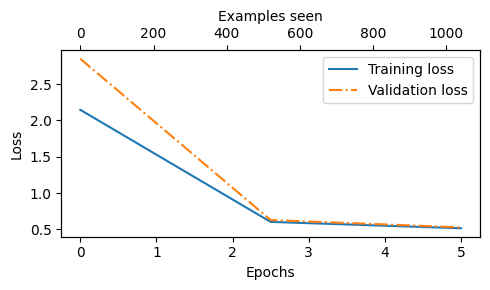

In [165]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

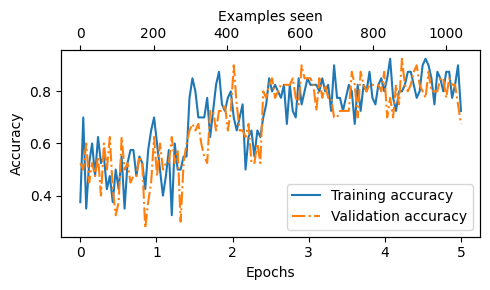

In [166]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [167]:
#calculating accuracy for whole dataset
train_accuracy=calc_accuracy_loader(train_loader,model,device,num_batches=10)
val_accuracy=calc_accuracy_loader(val_loader,model,device,num_batches=10)
test_accuracy=calc_accuracy_loader(test_loader,model,device,num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Testing accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 56.25%
Validation accuracy: 55.00%
Testing accuracy: 45.00%


In [168]:
#using the llm as a classifier for spam classification
#method is for single input message
def classify_review(text,model,tokenizer,device,max_length=None,pad_token_id=50256):
    #max-length: longest message length in the dataset

    input_ids=tokenizer.encode(text)
    supported_context_length=model.pos_emb.weight.shape[0] #shape of positional embedding=(1024 x 768)

    #truncate sequnes if they are too long
    input_ids=input_ids[:min(max_length,supported_context_length)]

    #adding end of token id to pad sequences if they are shorter than the max_length
    input_ids+=[pad_token_id]*(max_length-len(input_ids))
    input_tensor=torch.tensor(input_ids,device=device).unsqueeze(0) #add batch dimension


    with torch.no_grad():
        logits=model(input_tensor)[:,-1,:] #logits of the last output token
    predicted_label=torch.argmax(logits,dim=-1).item()

    return "spam" if predicted_label==1 else "not spam"

In [176]:
#example of a spam message
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [177]:
#example of a non spam message
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [ ]:
# #storing weights
# torch.save(model.state_dict(),"review_classifier.pth")

In [175]:
#loading weights into model
model_state_dict = torch.load("review_classifier.pth", map_location=torch.device("cpu"))
model.load_state_dict(model_state_dict)


<All keys matched successfully>